<a href="https://colab.research.google.com/github/marcosoliv26/classificacao_fraturas/blob/main/Projeto_2_unidade_Fratura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectar fraturas ósseas em imagens de raio-x utilizando redes neurais convolucionais (CNNs)

* As fraturas são interrupções ou quebras na continuidade do osso, resultantes de lesões, quedas ou traumas, e a análise de imagens de raio-x é um método tradicional para diagnosticá-las.
* A identificação manual de fraturas por radiologistas pode ser sujeita a erros devido à subjetividade, fadiga humana e, em muitos casos, à sutileza das fraturas.
* A detecção automática de fraturas ósseas, como as fraturas de avulsão, cominutiva, fratura-luxação, fratura em galho verde, fratura por linha fina, fratura impactada, longitudinal, oblíqua, patológica e espiral, pode ser realizada com redes neurais convolucionais (CNNs);
* A CNN analisa as imagens de raio-x para identificar padrões associados a essas lesões. As CNNs extraem características visuais diretamente das imagens e aprendem a diferenciar entre tipos de fraturas sutis e complexas, como fraturas de pequeno porte (linha fina) e fraturas mais graves, como a fratura cominutiva, onde o osso é fragmentado.

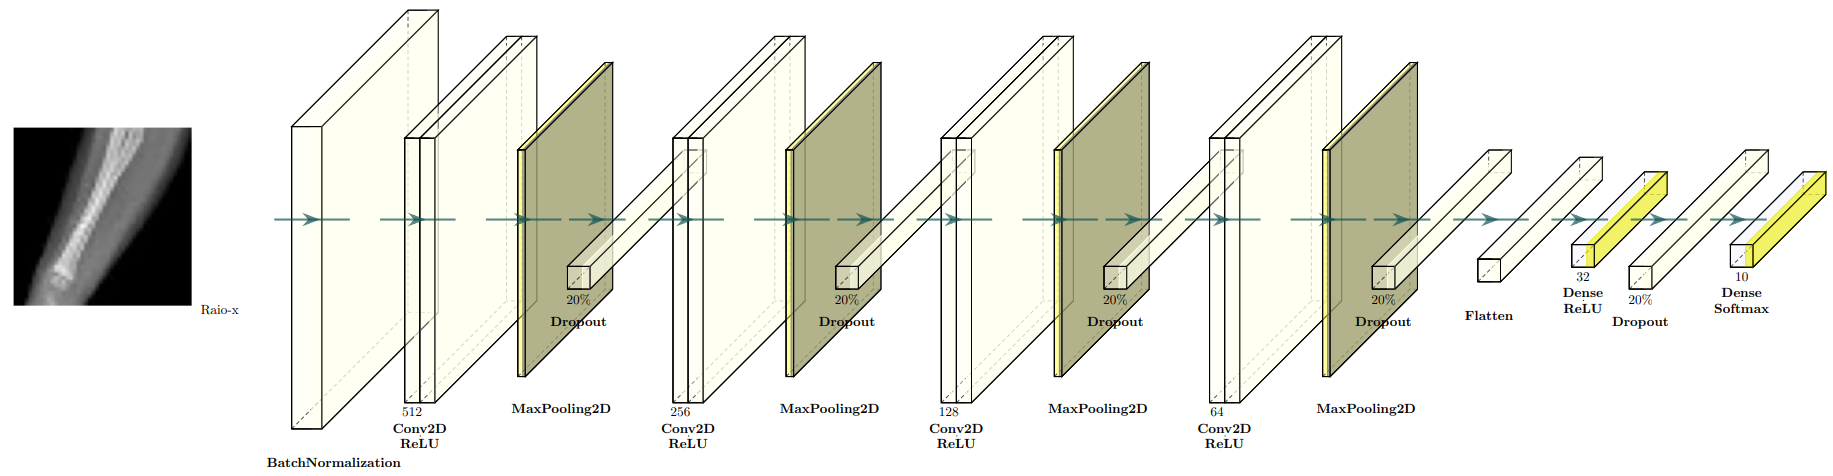

# 1. Importanto bibliotecas

In [ ]:
import cv2
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add, Input, AveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

# 2. CARREGANDO O DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 3. DESCOMPACTANDO O DATASET

In [ ]:
# caminho para o arquivo zip contendo os dados
zip_file = '/content/drive/MyDrive/DriveFraturas/archive (2).zip'

# diretório de destino para extrair os dados
extracted_dir_path = '/content/datasetNormal'

import zipfile
import os

# Extrair o arquivo zip
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Listar os arquivos no diretório de extração
extracted_files = os.listdir(extracted_dir_path)
print(f'Arquivos extraídos: {extracted_files}')

Arquivos extraídos: ['Bone Break Classification', 'README.dataset.txt']


# 4. ESTRUTURANDO O DATASET

In [ ]:
import numpy as np
import os, sys
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

folder = '/content/datasetNormal/Bone Break Classification/Bone Break Classification'
print(folder)


/content/datasetNormal/Bone Break Classification/Bone Break Classification


In [ ]:
image_width = 48
image_height = 48
channels = 1

train_files = []
i=0
for emotion in ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']:
    print(os.path.join(folder, emotion+'/Train'))
    onlyfiles = [f for f in os.listdir(os.path.join(folder, emotion+'/Train')) if os.path.isfile(os.path.join(folder, emotion+'/Train', f ))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

/content/datasetNormal/Bone Break Classification/Bone Break Classification/Avulsion fracture/Train
/content/datasetNormal/Bone Break Classification/Bone Break Classification/Comminuted fracture/Train
/content/datasetNormal/Bone Break Classification/Bone Break Classification/Fracture Dislocation/Train
/content/datasetNormal/Bone Break Classification/Bone Break Classification/Greenstick fracture/Train
/content/datasetNormal/Bone Break Classification/Bone Break Classification/Hairline Fracture/Train
/content/datasetNormal/Bone Break Classification/Bone Break Classification/Impacted fracture/Train
/content/datasetNormal/Bone Break Classification/Bone Break Classification/Longitudinal fracture/Train
/content/datasetNormal/Bone Break Classification/Bone Break Classification/Oblique fracture/Train
/content/datasetNormal/Bone Break Classification/Bone Break Classification/Pathological fracture/Train
/content/datasetNormal/Bone Break Classification/Bone Break Classification/Spiral Fracture/Trai

In [ ]:
i = 0
for emotion in ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']:
    onlyfiles = [f for f in os.listdir(os.path.join(folder, emotion+'/Train')) if os.path.isfile(os.path.join(folder, emotion+'/Train', f))]
    for _file in onlyfiles:
        img_path = os.path.join(folder, emotion+'/Train', _file)
        img = load_img(img_path, target_size=(image_height, image_width), color_mode='grayscale')
        x = img_to_array(img)
        dataset[i] = x
        mapping = {'Avulsion fracture': 0 , 'Comminuted fracture': 1, 'Fracture Dislocation': 2, 'Greenstick fracture': 3, 'Hairline Fracture': 4, 'Impacted fracture': 5, 'Longitudinal fracture': 6, 'Oblique fracture': 7, 'Pathological fracture': 8, 'Spiral Fracture': 9 }
        y_dataset.append(mapping[emotion])
        i += 1
        if i == 30000:
            print("%d images to array" % i)
            break

print("All images to array!")


All images to array!


# 5. NORMALIZANDO OS DADOS

In [ ]:
#Normalização
dataset = dataset.astype('float32')
dataset /= 255

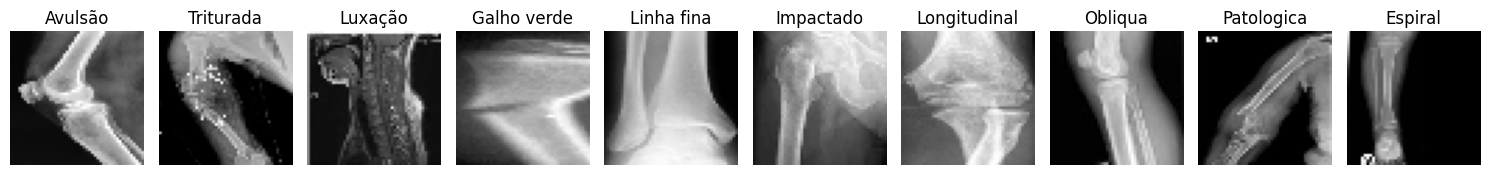

In [ ]:
import matplotlib.pyplot as plt

classes = ['Avulsão', 'Triturada', 'Luxação', 'Galho verde', 'Linha fina', 'Impactado', 'Longitudinal', 'Obliqua', 'Patologica', 'Espiral']

# Dicionário para armazenar o índice da primeira imagem de cada classe
first_image_index = {}

# Encontra o índice da primeira imagem de cada classe
for i, label in enumerate(y_dataset):
    if label not in first_image_index:
        first_image_index[label] = i

# Configura a grade para exibir as imagens
num_classes = len(set(y_dataset))
num_images_per_class = 1
num_cols = num_classes
num_rows = num_images_per_class

# Cria uma figura com uma grade de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Loop através de cada classe
for i in range(num_classes):
    # Obtém o índice da primeira imagem da classe
    idx = first_image_index[i]

    # Obtém a imagem e converte para RGB
    pixels = dataset[idx].reshape(image_height, image_width)

    # Exibe a imagem no subplot correspondente
    axes[i].imshow(pixels, cmap='gray')
    axes[i].axis('off')

    # Adiciona um título para o subplot com o rótulo
    axes[i].set_title(f'{classes[i]}')

# Exibe a figura
plt.tight_layout()
plt.show()

# 6.DIVIDINDO OS DADOS

* 60% PARA TREINO
* 20% PARA VALIDAÇÃO
* 20 % PARA TESTE

In [ ]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

10


In [ ]:
# Trim dataset to match the size of y_dataset_
dataset_trimmed = dataset[:len(y_dataset_)]

# Now both dataset_trimmed and y_dataset_ have the same size
# You can then proceed with splitting or any other operations

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset_trimmed, y_dataset_, test_size=0.2)

print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 791, Test set size: 198


BALANCEANDO OS DADOS DE TREINAMENTO

In [ ]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 7000

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")

Tamanho do conjunto de treinamento balanceado: 70000
Tamanho do conjunto de teste: 198
Classe 0: 7000 amostras
Classe 1: 7000 amostras
Classe 2: 7000 amostras
Classe 3: 7000 amostras
Classe 4: 7000 amostras
Classe 5: 7000 amostras
Classe 6: 7000 amostras
Classe 7: 7000 amostras
Classe 8: 7000 amostras
Classe 9: 7000 amostras


# MODELO DE REDE NEURAL CONVOLUCIONAL

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

# Criar o modelo
model = Sequential()

model.add(BatchNormalization(input_shape=(image_height, image_width, 1)))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Adiciona a camada de dropout
model.add(Dense(10, activation='softmax'))  # Especifica 'softmax' como a função de ativação

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 48, 48, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,486 (1.70 MB)

 Trainable params: 445,484 (1.70 MB)

 Non-trainable params: 2 (8.00 B)

4.COMPILANDO O MODELO

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Treinando o modelo
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Treinar o modelo
history = model.fit(balanced_X_train, balanced_y_train,validation_split= 0.2, epochs=200, callbacks=[early_stopping], batch_size=64)


Epoch 1/200
875/875 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.3987 - loss: 1.6549 - val_accuracy: 0.9914 - val_loss: 0.0619
Epoch 2/200
875/875 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.8963 - loss: 0.2902 - val_accuracy: 0.9916 - val_loss: 0.0232
Epoch 3/200
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.9365 - loss: 0.1749 - val_accuracy: 0.9932 - val_loss: 0.0180
Epoch 4/200
875/875 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9520 - loss: 0.1329 - val_accuracy: 0.9916 - val_loss: 0.0147
Epoch 5/200
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.9604 - loss: 0.1107 - val_accuracy: 0.9928 - val_loss: 0.0134
Epoch 6/200
473/875 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9636 - loss: 0.0959

KeyboardInterrupt: 

In [ ]:
val_accuracy = history.history['val_accuracy']

mean_val_accuracy = np.mean(val_accuracy)

print("Valor médio de acurácia:", mean_val_accuracy)

Valor médio de acurácia: 0.9927328052344145


In [ ]:
import pandas as pd
history_save = pd.DataFrame(history.history)
history_save.to_csv('datasetNormal.csv')

In [ ]:
# save model structure in jason file
model_json = model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save('modelosalvo.keras')

5. CARREGANDO O MODELO

In [ ]:
from keras.models import load_model

modelo_carregado = load_model('/content/modelosalvo.keras')

In [ ]:
import pandas as pd

history = pd.read_csv('/content/datasetNormal.csv')

5. PLOTANDO O MODELO

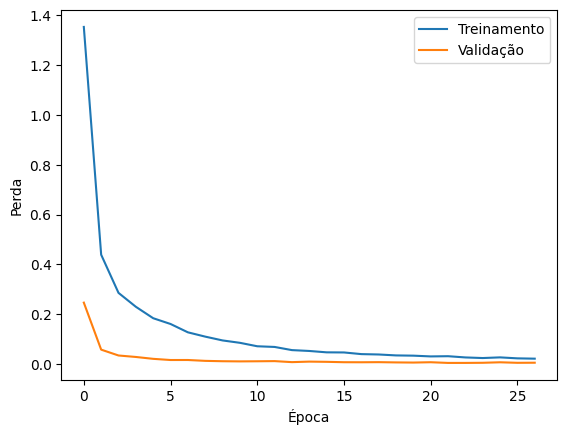

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])


plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc = 'upper right')
plt.show()


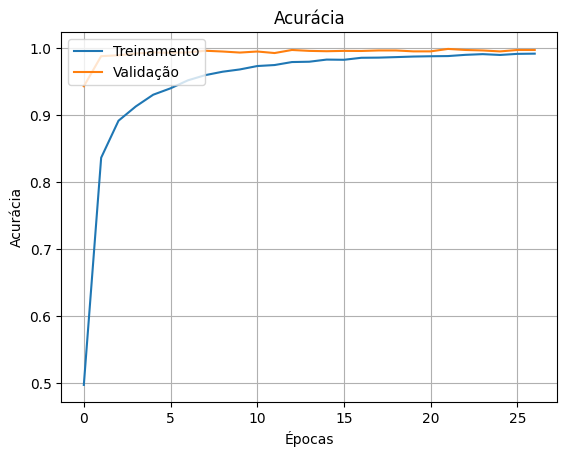

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.grid(True)
plt.show()
plt.close()

5. SALVANDO O MODELO

In [ ]:
preds = modelo_carregado.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


In [ ]:
#Função da Matriz de Confusão

def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues
    ):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

Confusion matrix, without normalization
[[ 6  1  4  0  3  0  5  0  3  2]
 [ 1 11  4  2  0  0  3  4  3  1]
 [ 2  2 16  0  2  0  0  0  3  0]
 [ 4  2  6 11  4  1  2  0  0  2]
 [ 4  0  5  1  7  2  1  1  2  1]
 [ 1  1  1  3  2  3  1  1  0  1]
 [ 0  0  1  2  0  1  1  0  2  1]
 [ 2  0  2  0  2  1  1  2  1  3]
 [ 1  0  2  0  2  0  0  0 12  1]
 [ 0  2  0  2  0  0  1  1  1  3]]


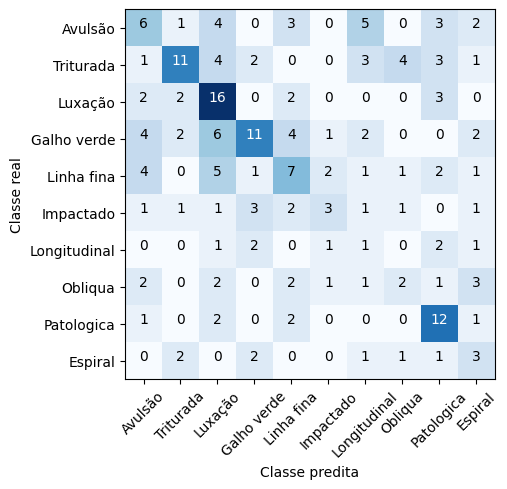

In [ ]:
#Gráfico da Matriz de Confusão

y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plot_confusion_matrix(cm, classes=['Avulsão', 'Triturada', 'Luxação', 'Galho verde', 'Linha fina', 'Impactado', 'Longitudinal', 'Obliqua', 'Patologica', 'Espiral'], title='Confusion matrix')
plt.show()
plt.close()

In [ ]:
# Calcular acurácia
accuracy = accuracy_score(y_test_, preds_)
print("Acurácia:", accuracy*float(100.0), "%")

# Calcular precisão
precision = precision_score(y_test_, preds_, average='micro')
print("Precisão:", precision*float(100.0), "%")

# Calcular recall
recall = recall_score(y_test_, preds_, average='micro')
print("Recall:", recall*float(100.0), "%")

# Calcular F1 score
f1 = f1_score(y_test_, preds_, average='micro')
print("F1-score:", f1*float(100.0), "%")

Acurácia: 36.36363636363637 %
Precisão: 36.36363636363637 %
Recall: 36.36363636363637 %
F1-score: 36.36363636363637 %


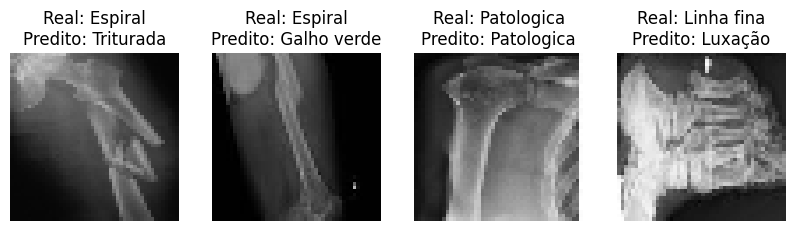

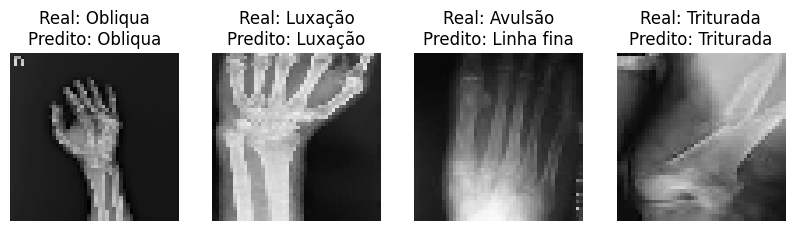

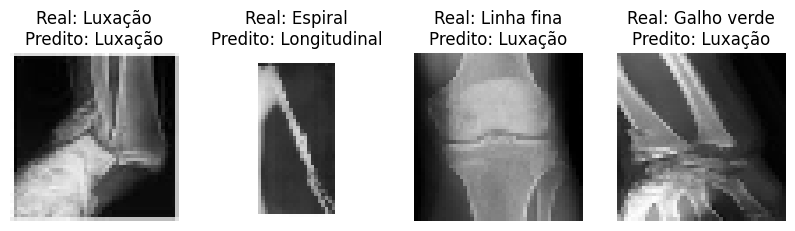

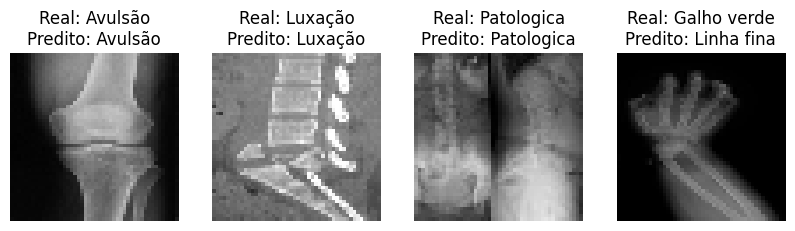

In [ ]:
#Resultado das predições

n = 4
for t in range(4):
    plt.figure(figsize=(10,10))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Real: {}\nPredito: {}'.format(classes[y_test_[i]], classes[preds_[i]]))
        plt.axis('off')
    plt.show()

In [ ]:
!pip install shap

import shap

In [ ]:
def normalize_shap_values(shap_values, epsilon=1e-8):
    normalized_shap = []
    for val in shap_values:
        min_val = np.min(val)
        max_val = np.max(val)
        # Evitar divisão por zero
        range_val = max_val - min_val + epsilon
        normalized_shap.append((val - min_val) / range_val)  # Normalizar para o intervalo [0, 1]
    return np.array(normalized_shap)

# Implementação do SHAP
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(modelo_carregado, background)

# Explicar as previsões para as primeiras 10 imagens de teste
shap_values = explainer.shap_values(X_test[:10])

# Normalizar os valores SHAP para o intervalo [0, 1]
normalized_shap_values = normalize_shap_values(shap_values)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(100, 48, 48, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(200, 48, 48, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(10, 48, 48, 1))']
 

In [ ]:
# Lista com as classes reais e preditas para cada imagem
real_classes = y_test
predicted_classes = preds_

# Títulos personalizados para as imagens da esquerda (classe real)
titles_left = [f'Real: {classes[np.argmax(real)]}' for real in real_classes]
# Títulos para as imagens da direita (classe predita)
titles_right = [f'Predito: {classes[pred]}' for pred in predicted_classes]


In [ ]:
titles_left = titles_left[:10]
titles_right = titles_right[:10]

<Figure size 1500x500 with 0 Axes>

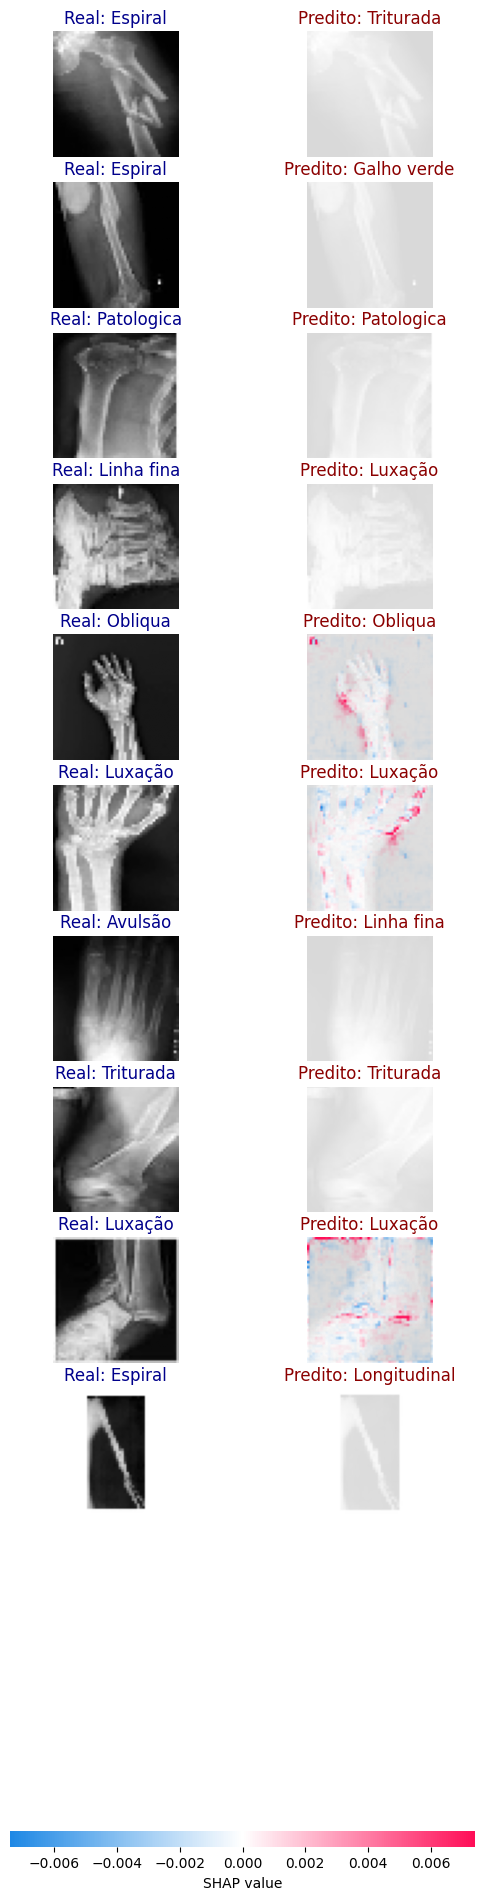

In [ ]:
# Criar o grid de 5x5 subplots
plt.figure(figsize=(15, 5))
# Plotar as imagens usando shap.image_plot com show=False para customização
shap.image_plot(shap_values, X_test[:10], show=False)
# Acessar todos os subplots e inserir títulos
axes = plt.gcf().axes
for i in range(0, len(titles_left) * 2, 2):  # Subplots da esquerda
    axes[i].set_title(titles_left[i // 2], fontsize=12, color="darkblue")

for i in range(1, len(titles_right) * 2, 2):  # Subplots da direita
    axes[i].set_title(titles_right[i // 2], fontsize=12, color="darkred")

#plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('shap_images.png', bbox_inches='tight')
plt.show()

Apesar do potencial, as CNNs aplicadas à detecção de fraturas ainda apresentam limitações, como a necessidade de grandes volumes de dados rotulados para treinamento e a dificuldade em interpretar as decisões do modelo (caixa preta). Portanto, modelos explicáveis e a integração com métodos de interpretação, como valores SHAP ou mapas de ativação, são importantes para garantir que os médicos confiem nos sistemas automatizados.